# **Loading Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau


# **Generate random message**

In [2]:
def message_gen(dataset_size):
  
  # my code
  m = np.array(np.random.randint(0, 2, (dataset_size, 11)))
  
  return m

# **Encoding (15,11) Hamming code**

Define the generator matrix and parity check matrix and encode the message

In [3]:
# encoding function
# def encoding(m,data_size):
def encoding(m):
  # my code
  # (15,11) Hamming Code Generator matrix
    P_T = np.array([
        [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]
    ])

    # 取得 P 矩陣 (P 是 P^T 的轉置)
    P = P_T.T

    # 建立 11x11 單位矩陣 I_11
    I_11 = np.eye(11, dtype=int)

    # 拼接 G 矩陣 [ I_11 | P ]
    G = np.hstack((I_11, P))

    
    c = np.mod(np.dot(m, G), 2)  # 編碼後的結果
    # m_modified = m
    return c
  # return c, m_modified

# **Modulation (BPSK)**

In [4]:
def modulation(c,SNR):
  # type your own code
  # assign the signal power based on the given SNR
  P = np.power(10,SNR/10)
  # implement the BPSK modulation
  x = np.sqrt(P)*(2*c - 1)
  return x

# **AWGN channel**

In [5]:
def AWGN_Channel(x):
  # assign the normalized noise
  n = np.random.normal(0,np.sqrt(1/2), x.shape)
  # return the receive signal y by transmitted signal x plus the noise n
  y = x + n
  return y

# **Splitting data into training and testing**

In [6]:
def splitting_data(y,m,rate,file_size):
  train_size = round(file_size*rate)
  test_size = file_size - train_size
  train_y = y[0:train_size,:]
  train_m = m[0:train_size]
  test_y = y[train_size:file_size,:]
  test_m = m[train_size:file_size]
  return train_y, train_m, test_y, test_m, train_size, test_size

In [7]:
def binary_array_to_decimal(arr):
    """
    將二維 binary array 轉為十進位整數
    arr: shape (N, bit_length)，每一列是一個二進位數字
    return: shape (N,) 的十進位整數
    """
    # arr.dot([2^(n-1), 2^(n-2), ..., 1])
    return arr.dot(2 ** np.arange(arr.shape[-1] - 1, -1, -1))

# Compiling the model

In [8]:
# def model_compile(SNR):
  # compile the model
  

# **Calculate BLER**

In [9]:
# def caculate_error(m_hat,m_class,file_size)
#   # my code
#   BLER = np.sum(m_hat != m_class) / file_size
#   return BLER

# Main Function

In [10]:
%%time
SNR_start = 0
SNR_end = 6
step_size = 1
SNR = np.arange(SNR_start,SNR_end+1,step_size)
length_SNR = len(SNR)
BLER = np.zeros(length_SNR)
rate = 0.7 # training data rate
# datasetsize4SNR = np.array([1e4, 1e4, 1e4, 1e4, 1e4, 1e5, 1e5],dtype=int)
datasetsize4SNR = np.array([1e5, 1e5, 1e5, 1e5, 1e5, 2e5, 3e5], dtype=int)

# lr_schedule = np.array([0.00008, 0.001, 0.001, 0.001, 0.005, 0.008, 0.00007],dtype=float)
lr_schedule = np.array([0.005, 0.005, 0.005, 0.005, 0.0005, 0.0005, 0.0005], dtype=float)

num_epochs = np.array([20, 20, 20, 20, 20, 20, 20],dtype=int)
# num_epochs = np.array([20, 20, 20, 20, 20, 20, 40], dtype=int)

# datasetsize4SNR = np.array([1e1, 1e1, 1e1, 1e1, 1e1, 1e1, 1e5],dtype=int)

unique_category_count = 2**11

for i in range(length_SNR):

  #------------------------------------#
  # transmitter part
  #------------------------------------#
  # generate message
  m = message_gen(datasetsize4SNR[i])
  
  # generate codeword
  c = encoding(m)

  # BPSK modulation
  x = modulation(c,SNR[i])

  # go through AWGN channel
  y = AWGN_Channel(x)

  #------------------------------------#
  # receiver part
  #------------------------------------#
  # decoding by deep learning
  # split data
  [train_y, train_m, test_y, test_m, train_size, test_size] = splitting_data(y,m,rate,datasetsize4SNR[i])
  # print(train_m[0:10])
  train_m = binary_array_to_decimal(train_m)
  test_m = binary_array_to_decimal(test_m)
  
  train_m_OneHot = tf.one_hot(train_m, unique_category_count)
  test_m_OneHot = tf.one_hot(test_m, unique_category_count)
  

  # define model
  # if i >= 4:
  model = keras.models.Sequential([
        keras.layers.Dense(128, activation='gelu', input_shape=(15,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(256, activation='gelu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='gelu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(64, activation='gelu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(unique_category_count, activation='softmax')
  ])

  # else:
  #   model = keras.models.Sequential([
  #       keras.layers.Dense(48, activation='elu', input_shape=(15,)),
  #       keras.layers.BatchNormalization(),
  #       keras.layers.Dropout(0.2),
  #       keras.layers.Dense(128, activation='elu'),
  #       keras.layers.BatchNormalization(),
  #       keras.layers.Dropout(0.3),
  #       keras.layers.Dense(48, activation='elu'),
  #       keras.layers.BatchNormalization(),
  #       keras.layers.Dropout(0.2),
  #       keras.layers.Dense(32, activation='elu'),
  #       keras.layers.BatchNormalization(),
  #       keras.layers.Dense(unique_category_count, activation='softmax')
  #   ])

  
  # num_epochs = 20
  batch_size = 128

  # lr_schedule = ExponentialDecay(0.001, train_size // 64 * num_epochs, 0.8, staircase=True)
  # lr_schedule = 0.0001
  # lr_schedule_fn = tf.keras.optimizers.schedules.CosineDecay(
  #       initial_learning_rate,
  #       decay_steps=train_size // batch_size * num_epochs[i],
  #       alpha=0.3
  # )
  initial_learning_rate = lr_schedule[i]
  
  optimizer = Adam(learning_rate=initial_learning_rate)

  
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',        # 根據驗證損失判斷是否調整學習率
      factor=0.5,                # 每次減少學習率的倍率（例如：0.5 表示減半）
      patience=2,                # 容忍多少個 epoch 沒有改善就降學習率
      min_lr=1e-6,               # 最小學習率下限
      verbose=1                  # 顯示學習率調整訊息
  )
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # training and fitting model
  history = model.fit(train_y, train_m_OneHot, epochs=num_epochs[i], batch_size=batch_size, validation_data=(test_y, test_m_OneHot), verbose=1, callbacks=[reduce_lr])
  # plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  # plt.legend(['training', 'validation'], loc = 'upper left')
  # plt.show()
  # predict by the model
  m_hat = model.predict(test_y)

  # calculate error

  # predict model
  err = np.sum(np.argmax(m_hat, axis=1) != np.argmax(test_m_OneHot, axis=1))

  # calculate BLER
  BLER[i] = err/test_size
  print("BLER: ",BLER[i])
  print(i,"/",len(BLER)-1)


Epoch 1/20
547/547 [==============================] - 5s 7ms/step - loss: 3.3377 - accuracy: 0.3424 - val_loss: 1.5474 - val_accuracy: 0.6054 - lr: 0.0050
Epoch 2/20
547/547 [==============================] - 4s 7ms/step - loss: 1.5473 - accuracy: 0.6012 - val_loss: 1.2762 - val_accuracy: 0.6715 - lr: 0.0050
Epoch 3/20
547/547 [==============================] - 4s 7ms/step - loss: 1.3176 - accuracy: 0.6520 - val_loss: 1.2044 - val_accuracy: 0.6866 - lr: 0.0050
Epoch 4/20
547/547 [==============================] - 4s 7ms/step - loss: 1.2155 - accuracy: 0.6754 - val_loss: 1.1779 - val_accuracy: 0.6962 - lr: 0.0050
Epoch 5/20
547/547 [==============================] - 4s 7ms/step - loss: 1.1471 - accuracy: 0.6877 - val_loss: 1.1598 - val_accuracy: 0.7012 - lr: 0.0050
Epoch 6/20
547/547 [==============================] - 4s 7ms/step - loss: 1.0927 - accuracy: 0.7018 - val_loss: 1.1349 - val_accuracy: 0.7070 - lr: 0.0050
Epoch 7/20
547/547 [==============================] - 4s 7ms/step - lo

Block Error Rate: [2.52666667e-01 1.40900000e-01 6.69666667e-02 2.31333333e-02
 6.30000000e-03 7.83333333e-04 4.44444444e-05]


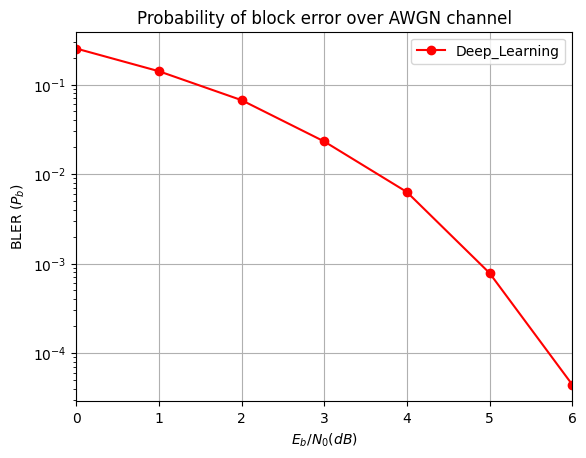

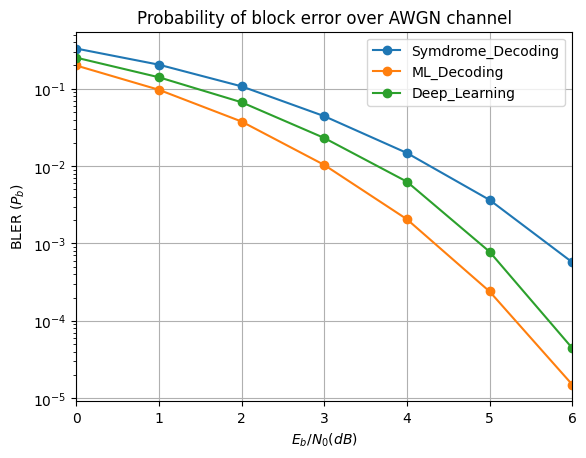

姓名: 賴昱凱, 學號: 111511141


In [11]:
#Reuse the results of last time
BLER_SymdromeDecoding = [0.33146, 0.20494, 0.10756, 0.04429, 0.0148, 0.00366, 0.0005725]
BLER_ML = [1.9999e-01, 9.7070e-02, 3.7740e-02, 1.0370e-02, 2.0600e-03, 2.4000e-04, 1.5000e-05]
#Plot BLER
EbN0dBs = np.arange(start=SNR_start,stop=SNR_end+1,step=step_size)
fig1 = plt.figure(1)
plt.semilogy(EbN0dBs,BLER,color='r',marker='o',linestyle='-',label='Deep_Learning')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BLER ($P_b$)')
plt.title('Probability of block error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
print("Block Error Rate:", BLER)
fig2 = plt.figure(2)
plt.semilogy(EbN0dBs,BLER_SymdromeDecoding[SNR_start:SNR_end+1],marker='o',linestyle='-',label='Symdrome_Decoding')
# plt.semilogy(EbN0dBs,BLER_SVM[SNR_start:SNR_end+1],marker='o',linestyle='-',label='SVM')
plt.semilogy(EbN0dBs,BLER_ML[SNR_start:SNR_end+1],marker='o',linestyle='-',label='ML_Decoding')
plt.semilogy(EbN0dBs,BLER,marker='o',linestyle='-',label='Deep_Learning')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BLER ($P_b$)')
plt.title('Probability of block error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
plt.show()
print("姓名: 賴昱凱, 學號: 111511141")